In [3]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
from myUtils import *

# rootPath = "../../results/scenario/geothermal"
# rootPath = "../../results/scenario/biogas"
# rootPath = "../../results/scenario/PHS"
rootPath = "../../results/scenario/PHS"
# rootPath = "../../results/scenario/battery"




plt.style.use('bmh')
%matplotlib inline

# n = pypsa.Network("../../results/base/base27Node2045/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# nMean = pypsa.Network(rootPath + "-mean/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# nOptimist = pypsa.Network(rootPath + "-optimist/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# n = pypsa.Network(rootPath + "/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")

# n = pypsa.Network("../../results/scenario/h2-best/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# n = pypsa.Network("../../results/scenario/h2-de/postnetworks/base_s_20_lvopt_3H_3H_2045.nc")
# n = pypsa.Network("../../results/scenario/h2-idea/postnetworks/base_s_27_lc1_3H_3H_2045.nc")
n = pypsa.Network("../../results/scenario-old/h2/postnetworks/base_s_27_lc1_3H_3H_2045.nc")


INFO:pypsa.io:Imported network base_s_27_lc1_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


```
1 kW= 1e3 W               1 KWH = 1e3 WH             1 Tsd EUR = 1e3 EUR
1 MW = 1e6 W = 1 MW       1 MWH = 1e6 WH = 1 MWH     1 Mio.EUR = 1e6 EUR
1 GW = 1e9 W = 1e3 MW     1 GWH = 1e9 WH = 1e3 MWH   1 Mrd.EUR = 1e9 EUR
1 TW = 1e12 W = 1e6 MW    1 TWH = 1e12 WH = 1e6 MWH  1 Bio.EUR = 1e12 EUR


```

<Axes: xlabel='snapshot'>

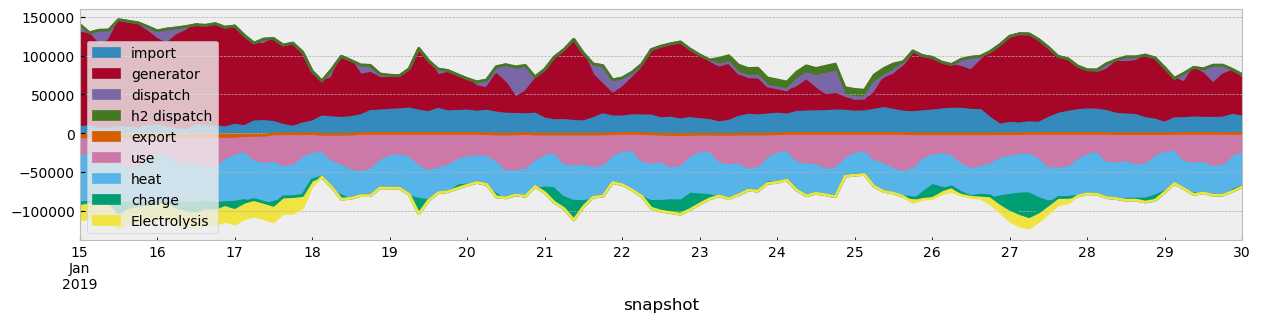

In [4]:
import myUtils as utils
import pandas as pd

import importlib
importlib.reload(utils)

df = pd.DataFrame(index = n.snapshots)


importLinkIds = utils.de_import_elec_grouper(n, 'Link').tolist()
importLinIds = utils.de_import_elec_grouper(n, 'Line').tolist()
importLineRIDS = utils.de_import_elec_reverse_grouper(n, 'Line').tolist()

df['import'] = - n.links_t.p1[importLinkIds].sum(axis=1) \
  - n.lines_t.p1[importLinIds].clip(upper=0).sum(axis=1) \
  - n.lines_t.p0[importLineRIDS].clip(upper=0).sum(axis=1)


generatorGeneratorIds =  utils.de_generator_grouper(n, 'Generator').tolist()
generatorLinkIds =  utils.de_generator_grouper(n, 'Link').tolist()
df['generator'] =  n.generators_t.p[generatorGeneratorIds].sum(axis=1) \
   - n.links_t.p1[generatorLinkIds].sum(axis=1)


storeStorageIds = utils.de_elec_store_grouper(n, 'StorageUnit').tolist()
storeStoreIds = utils.de_elec_store_grouper(n, 'Store').tolist()
df['dispatch'] = n.storage_units_t.p_dispatch[storeStorageIds].sum(axis=1) \
  + n.stores_t.p[storeStoreIds].clip(lower=0).sum(axis=1)

ids = utils.de_h2_dispatch_grouper(n, 'Link').tolist()
df['h2 dispatch'] = - n.links_t.p1[ids].sum(axis=1)
# use
exportLinkIds = utils.de_export_elec_grouper(n, 'Link').tolist()
exportLinIds = utils.de_export_elec_grouper(n, 'Line').tolist()
df['export'] = - n.links_t.p0[exportLinkIds].sum(axis=1) \
  - n.lines_t.p0[exportLinIds].clip(lower=0).sum(axis=1) \
  - n.lines_t.p1[importLineRIDS].clip(upper=0).sum(axis=1)


useLinkIds = utils.de_elec_use_grouper(n, 'Link').tolist()
useLoadIds = utils.de_elec_use_grouper(n, 'Load').tolist()

df['use'] = - n.loads_t.p[useLoadIds].sum(axis=1) 
           
df['heat'] =  -n.links_t.p0[useLinkIds].clip(lower=0).sum(axis=1)

storeStorageIds = utils.de_elec_store_grouper(n, 'StorageUnit').tolist()
storeStoreIds = utils.de_elec_store_grouper(n, 'Store').tolist()
useElectrolysisIds = utils.de_h2_Electrolysis_grouper(n, 'Link').tolist()
df['charge'] = - n.storage_units_t.p_store[storeStorageIds].sum(axis=1)\
  + n.stores_t.p[storeStoreIds].clip(upper=0).sum(axis=1) 

df['Electrolysis'] = - n.links_t.p0[useElectrolysisIds].sum(axis=1) 

total_use = (df['export'] + df['use'] + df['charge'] + df['heat'])
total_produce= (df['import'] + df['generator'] + df['dispatch'])


df['2019-1-15 00:00:00': '2019-1-30 00:00:00'].plot(kind='area', figsize=(15,3))


In [6]:
a ={'a':0}
a.get('b',0)

0

In [119]:
capex =n.statistics.capex(groupby=["carrier", "de_generator_grouper"]).groupby("carrier").sum() / 1e6  
opex = n.statistics.opex(groupby=["carrier", "de_generator_grouper"]).groupby("carrier").sum() / 1e3
optimal_capacity = n.statistics.optimal_capacity(groupby=["carrier", "de_generator_grouper"]).groupby("carrier").sum() / 1e3
curtailment = n.statistics.curtailment(groupby=["carrier", "de_generator_grouper"]).groupby("carrier").sum() / 1e3
supply = n.statistics.supply(groupby=["carrier", "de_generator_grouper"]).groupby("carrier").sum() / 1e3

# result_df = pd.DataFrame({
#     'CAPEX': capex,
#     'OPEX': opex,
#     'Optimal Capacity': optimal_capacity,
#     'supply': supply,
#     "curtailment": curtailment,
   
# })



# table = dataframe_to_table(result_df)
# print(table)

optimal_capacity

carrier
Offshore Wind (AC)                  1.25053
Offshore Wind (DC)                  5.78421
Offshore Wind (Floating)            0.52025
Onshore Wind                      145.74505
Open-Cycle Gas                      0.00004
Run of River                        2.70288
Solar                              50.28718
nuclear                             4.06600
solar rooftop                      25.43749
solar-hsat                          0.00009
urban central CHP                   0.00004
urban central solid biomass CHP     0.00002
dtype: float64

In [130]:
optimal_capacity = n.statistics.optimal_capacity(groupby=["carrier", "de_h2_turbine_grouper"]).groupby("carrier").sum() / 1e3
ids = utils.de_h2_FC_grouper(n, 'Link').tolist()
n.links.loc[ids]['p_nom_opt'].sum() / 1e3

15.645417679491924

In [132]:
optimal_capacity = n.statistics.optimal_capacity(groupby=["carrier", "de_h2_turbine_grouper"]).groupby("carrier").sum() / 1e3
optimal_capacity

carrier
H2 turbine   123.73801
dtype: float64

In [141]:
optimal_capacity = n.statistics.optimal_capacity(groupby=["carrier", "de_h2_turbine_grouper"]).groupby("carrier").sum() / 1e3

optimal_capacity

carrier
H2 turbine   123.73801
dtype: float64

<Axes: xlabel='snapshot'>

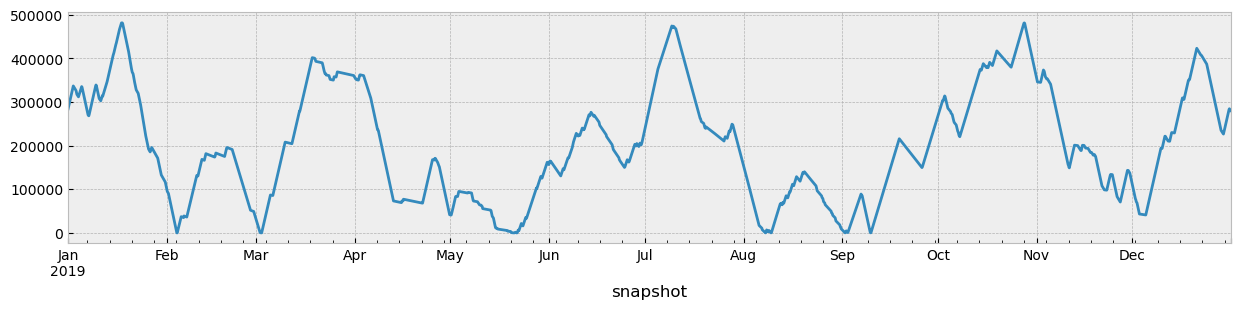

In [115]:

n.stores_t.e['DE0 2 H2 Store'].plot(figsize=(15,3))

In [98]:
n.stores.loc['DE0 1 H2 Store']

bus                             DE0 1 H2
type                                    
carrier                         H2 Store
e_nom                            0.00000
e_nom_mod                        0.00000
e_nom_extendable                    True
e_nom_min                        0.00000
e_nom_max                 59762995.53848
e_min_pu                         0.00000
e_max_pu                         1.00000
e_initial                        0.00000
e_initial_per_period               False
e_cyclic                            True
e_cyclic_per_period                 True
p_set                            0.00000
q_set                            0.00000
sign                             1.00000
marginal_cost                    0.01025
marginal_cost_quadratic          0.00000
marginal_cost_storage            0.00000
capital_cost                    45.03390
standing_loss                    0.00000
active                              True
build_year                             0
lifetime        

In [ ]:
t = n.iterate_components()
for t in n.iterate_components():
  print(t.name)
  t.df[]

Link
Link
relation/10377412-320-DC                       1189.44203
relation/13295785-515-DC                       1699.01235
relation/14126301-450-DC                        754.90679
relation/15772117-320-DC                       1189.44203
relation/15781671-525-DC                       1199.40000
relation/16213216-525-DC                       1394.80024
relation/17631956-250-DC                        792.38087
relation/2127794-270-DC                        1189.44203
relation/2505320-400-DC                         407.59098
relation/3391794-200-DC                         425.65264
relation/3391931-350-DC                         952.27914
relation/3392010-450-DC                        1509.71383
relation/3918230-450-DC                        1301.67359
relation/5487095-400-DC                         260.50143
relation/6914309-500-DC                         460.78966
relation/8184629-300-DC                         938.26539
relation/8184632-500-DC                         952.27914
rela

KeyError: 'length'

In [53]:
for t in n.iterate_components(["Line", "Link"]):
    print(t.df['length'])

Line
0     680.19885
1     395.92668
10    666.18395
11    464.23509
12    431.48716
13    497.50253
14    356.60323
15    400.92923
16    581.46552
17    307.01614
18    251.78442
19    280.77237
2     546.78484
20    258.38915
21    211.46037
22    386.80766
23    277.39751
24    477.94987
25    241.46137
26    444.26909
27    330.10713
28    479.24248
29    712.37752
3     287.16086
30    411.95250
31    355.73623
32    326.80101
33    897.58785
34   1319.77352
35   1144.39131
36    537.24921
37    585.34135
4     724.91331
5     639.34518
6     215.51030
7     265.10849
8     305.78193
9     578.30395
Name: length, dtype: float64
Link
relation/10377412-320-DC                       1189.44203
relation/13295785-515-DC                       1699.01235
relation/14126301-450-DC                        754.90679
relation/15772117-320-DC                       1189.44203
relation/15781671-525-DC                       1199.40000
relation/16213216-525-DC                       1394.80024
relat

In [101]:
import numpy as np
a = 1e-2 + 2e-3 * (
                    0.5 - 0.5
                )
a


0.01

In [71]:

a =                 1e-1 + 2e-2 * (np.random.random(5000) - 0.5)
a.mean()
            

0.1000085354970763